In [160]:
import uproot
from uncertainties import unumpy
from uncertainties import ufloat
import uncertainties
from scipy.optimize import curve_fit
import numpy as np
import mplhep as hep
import copy
import matplotlib.pyplot as plt

In [161]:
from uproot_plotting_tools.Hist import Hist1D
from uproot_plotting_tools.Systematics import Systematics
from uproot_plotting_tools.utils import *

In [162]:
def add_categories(category,samples):
    bckground = Sample(category)
    bin_edges = samples[0].regions['CR10'].bin_edges
    bckground.reset_plot(bin_edges)
    n_samples = 0
    for sample in samples:
        if sample.category == category:
            bckground = bckground.add(sample)
    return bckground


def get_val_var(x): return x.val, x.var
def divide_Hist1D(x,y): 
    bin_edges = x.bin_edges
    name = "{}/{}".format(x.name,y.name)
    x_val,x_var = get_val_var(x)
    y_val,y_var = get_val_var(y)
    x_var = safe_divide(x_var,y_val**2)
    x_val = safe_divide(x_val,y_val)
    #y_val = safe_divide(y_val,y_val)
    #y_var = safe_divide(y_var,y_val)
    
    return Hist1D(bin_edges,x_val,x_var,name = name)

def abcd_fit(bins, 
    norm_mumu_j, norm_ee_b, norm_ee_j,
    sigma_mumu_j, sigma_ee_b, sigma_ee_j,
    theta_mumu_j, theta_ee_b, theta_ee_j,
    mean_mumu_j, mean_ee_b, mean_ee_j,
    slope_mumu_j, slope_ee_b, slope_ee_j,
             numpy_like=np):
    
    popt = np.asarray([ norm_mumu_j, norm_ee_b, norm_ee_j,
    sigma_mumu_j, sigma_ee_b, sigma_ee_j,
    theta_mumu_j, theta_ee_b, theta_ee_j,
    mean_mumu_j, mean_ee_b, mean_ee_j,
    slope_mumu_j, slope_ee_b, slope_ee_j,])
    popt.shape
    bins = np.array(bins)
    mumu_j = log_norm(bins, norm_mumu_j, sigma_mumu_j, theta_mumu_j, mean_mumu_j, slope_mumu_j,numpy_like=numpy_like)
    ee_b = log_norm(bins, norm_ee_b, sigma_ee_b, theta_ee_b, mean_ee_b, slope_ee_b,numpy_like=numpy_like)
    ee_j = log_norm(bins, norm_ee_j, sigma_ee_j, theta_ee_j, mean_ee_j, slope_ee_j,numpy_like=numpy_like)
    return list(mumu_j)+list(ee_b)+list(ee_j)

def make_abcd_subplots(njets,bckground,data):
    fig, ax = abcd_template(("mumu_b","mumu_j","ee_b","ee_j"),yscale="log")

    regions = ['SR{}','CR{}0','CR{}3','CR{}4']
    nJet = 1

    for i, reg in enumerate(regions):
        reg = reg.format(njets)
        bck = bckground.regions_range[reg]
        dt = data.regions_range[reg]
        bck_name = bckground.name
        dt_name = data.name
        bck_h = bck.plot(ax[i][0],kwargs={"label":bck_name})
        dt_h = dt.plot(ax[i][0],kwargs={"label":dt_name})
        chi2 = bck.chi_squared(dt)
        ax[i][0].plot([], [], ' ', label="chi2: {:.2f}".format(chi2))
        divide_Hist1D(bck,dt).plot(ax[i][1])
        divide_Hist1D(dt,dt).plot(ax[i][1])
        ax[i][0].legend()
    ax[0][0].set_ylim(bottom=.5)
    fig.savefig("output/nJets_{}_{}_{}.pdf".format(njets,bck_name,dt_name,era))
    
xmin = 140
xmax =300
def abcd_fiter(sample, njets):
    bin_center, SR, CR = sample.abcd_assets(njets)
    bin_edges = sample.regions_range['SR1'].bin_edges
    popt,pcov = curve_fit(abcd_fit,bin_center,CR[0],
                    p0=np.asarray([
1000.21,98.72,723.70,
0.72, 0.62, 0.72,
127.62, 106.32, 127.34,
88.79,114.07,90.59,
0.99,0.96,1.00,]),
                    bounds=(0, [
                            np.inf, np.inf, np.inf,
                            np.inf, np.inf, np.inf,
                            xmin-1, xmin-1, xmin-1,
                            np.inf, np.inf, np.inf,
                            np.inf, np.inf, np.inf,
                    ]),
                    sigma = (CR[1]),
                    absolute_sigma=True)
    #print("fit: {} cov: {}".format(popt,pcov))
    var = ["norm_mumu_j", "norm_ee_b", "norm_ee_j",
"sigma_mumu_j", "sigma_ee_b", "sigma_ee_j",
"theta_mumu_j", "theta_ee_b", "theta_ee_j",
"mean_mumu_j", "mean_ee_b", "mean_ee_j",
"slope_mumu_j", "slope_ee_b", "slope_ee_j",]
    for val,name in list(zip(popt,var)):
           print("{}: {:.2f}".format(name,val))
    corr_values = uncertainties.correlated_values(popt, pcov)
    mumu_j,ee_b,ee_j = np.asarray(abcd_fit(bin_center,*corr_values,numpy_like=unumpy)).reshape(3,-1)
    fits = [mumu_j*ee_b/ee_j, mumu_j,ee_b,ee_j]
    fit_hists = []
    names = ["mumu_b","mumu_j","ee_b","ee_j"]
    for fit,name in zip(fits,names):
        val, var = to_nom_std(fit)
        fit_hists.append(Hist1D(bin_edges, val, var,name=name))
    return fit_hists, popt

In [163]:
popt = np.asarray([1000.21,98.72,723.70,
0.72, 0.62, 0.72,
127.62, 106.32, 127.34,
88.79,114.07,90.59,
0.99,0.96,1.00,])
popt.shape = (-1,3)
popt

array([[1.00021e+03, 9.87200e+01, 7.23700e+02],
       [7.20000e-01, 6.20000e-01, 7.20000e-01],
       [1.27620e+02, 1.06320e+02, 1.27340e+02],
       [8.87900e+01, 1.14070e+02, 9.05900e+01],
       [9.90000e-01, 9.60000e-01, 1.00000e+00]])

In [164]:
era=18

In [165]:
hep.set_style(hep.style.ROOT)

In [166]:
if era == 18: 
    uproot_file = uproot.open("samplesCR_2018_v6_lo_test.root")
    #from param_dict_18 import param_dict
    lumi=58.877
if era == 17: 
    uproot_file = uproot.open("samplesCR_2017_v6_lo_test.root")
    #from param_dict_17 import param_dict
    lumi=41.86
    
if era == 16: 
    uproot_file = uproot.open("samplesCR_2016_v7_test.root")
    #from param_dict_16 import param_dict
    lumi=35.5

In [194]:
class Sample:
    def __init__(self,name,label=0,category=0,kwargs={},uproot_obj=0,hname="{}_nominal_no_zPeak_DiLepMass",xrange=(-np.inf,np.inf)):
        self.name = name
        self.label = label
        self.category = category
        self.kwargs = kwargs
        self.regions = {"SR1":0,"CR10":0,"CR13":0,"CR14":0,"SR2":0,"CR20":0,"CR23":0,"CR24":0}
        self.bins = 0
        self.hname = hname
        self.xrange = xrange
        if uproot_obj: 
            self.uproot_obj = uproot_obj
            self.get_plots()
    @classmethod
    def from_regions(cls,name,regions,kwargs={}):
        temp_cls = cls(name,**kwargs)
        temp_cls.regions = copy.deepcopy(regions)
        return temp_cls
    @property
    def regions_range(self):
        regions = {}
        for key in self.regions:
            regions[key] = self.regions[key].range(*self.xrange)
        return regions
    def get_plots(self):
        for key in self.regions:
            hname = "{}/{}".format(self.name,self.hname).format(key)
            print(hname)
            hist = Hist1D.from_uproot(self.uproot_obj[hname])
            self.regions[key] = hist
    def reset_plot(self,bin_edges):
        for key in self.regions:
            n_bins = len(bin_edges) - 1
            self.regions[key] = Hist1D(bin_edges, np.full(n_bins,0), np.full(n_bins,0))
    def add(self,other):
        new_regions = {}
        for key in self.regions:
                new_regions[key] = self.regions[key].add(other.regions[key])
        name = "{} + {}".format(self.name,other.name)
        return Sample.from_regions(name,new_regions)
    def __repr__(self):
        return "Name: {} Cat: {} regions: {}".format(self.name, self.category, self.regions)
    def abcd_assets(self,njets):
        target = 'SR{}'.format(njets)
        control_regions = ['CR{}0'.format(njets),'CR{}3'.format(njets),'CR{}4'.format(njets)]
        regions = self.regions_range
        target = regions[target]
        print(repr(target))
        bin_center = target.bin_center()
        val_list = []
        std_list = []
        for reg in control_regions:
            val_list += list(regions[reg].val)
            stdev = regions[reg].stdev()
            stdev[-1] = 9999
            stdev[0] = 9999
            std_list += list(stdev)
        return bin_center, np.asarray([target.val,target.stdev()]), np.asarray([val_list, std_list])
        

samples = [
Sample('data_el', label='data', category='data', kwargs={'color': 'black'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('data_mu', label='data', category='data', kwargs={'color': 'black'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('BFFZprimeToMuMu_M_200', label='200 $\delta_{bs}=0.04$', category='signal', kwargs={'color': '#6633ff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('BFFZprimeToMuMu_M_200_dbs0p5', label='200 $\delta_{bs}=0.5$', category='signal', kwargs={'color': '#3900e6','linestyle':'--'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('BFFZprimeToMuMu_M_200_dbs1p0', label='200 $\delta_{bs}=1.0$', category='signal', kwargs={'color': '#260099','linestyle':'-.'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('BFFZprimeToMuMu_M_350', label='350 $\delta_{bs}=0.04$', category='signal', kwargs={'color': '#ff33ff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('BFFZprimeToMuMu_M_350_dbs0p5', label='350 $\delta_{bs}=0.5$', category='signal', kwargs={'color': '#e600e6','linestyle':'--'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('BFFZprimeToMuMu_M_350_dbs1p0', label='350 $\delta_{bs}=1.0$', category='signal', kwargs={'color': '#990099','linestyle':'-.'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('BFFZprimeToMuMu_M_500', label='500 $\delta_{bs}=0.04$', category='signal', kwargs={'color': '#ff3366'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('BFFZprimeToMuMu_M_500_dbs0p5', label='500 $\delta_{bs}=0.5$', category='signal', kwargs={'color': '#e60039','linestyle':'--'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('BFFZprimeToMuMu_M_500_dbs1p0', label='500 $\delta_{bs}=1.0$', category='signal', kwargs={'color': '#990026','linestyle':'-.'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('mc_zz', label='WW/WZ/ZZ', category='background', kwargs={'color': '#ccffcc'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('mc_wz', label='WW/WZ/ZZ', category='background', kwargs={'color': '#ccffcc'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('mc_ww', label='WW/WZ/ZZ', category='background', kwargs={'color': '#ccffcc'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('mc_stop', label='ST', category='background', kwargs={'color': '#ffccff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('mc_santitop', label='ST', category='background', kwargs={'color': '#ffccff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('mc_ttbar', label='TT', category='background', kwargs={'color': '#ffff99'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('ZToMuMu_M_50_120', label='DY', category='background', kwargs={'color': '#99ffff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('ZToMuMu_M_120_200', label='DY', category='background', kwargs={'color': '#99ffff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('ZToMuMu_M_200_400', label='DY', category='background', kwargs={'color': '#99ffff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('ZToMuMu_M_800_1400', label='DY', category='background', kwargs={'color': '#99ffff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('ZToMuMu_M_400_800', label='DY', category='background', kwargs={'color': '#99ffff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('ZToEE_M_50_120', label='DY', category='background', kwargs={'color': '#99ffff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('ZToEE_M_120_200', label='DY', category='background', kwargs={'color': '#99ffff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('ZToEE_M_200_400', label='DY', category='background', kwargs={'color': '#99ffff'}, uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('ZToEE_M_800_1400', label='DY', category='background', kwargs={'color': '#99ffff'},uproot_obj=uproot_file, xrange=(xmin,xmax)),
Sample('ZToEE_M_400_800', label='DY', category='background', kwargs={'color': '#99ffff'},uproot_obj=uproot_file, xrange=(xmin,xmax)),
    ]

for sample in samples:
    if sample.category == "data":
        sample.regions['SR1'].reset()
        sample.regions['SR2'].reset()
        print(sample)

data_el/SR1_nominal_no_zPeak_DiLepMass
data_el/CR10_nominal_no_zPeak_DiLepMass
data_el/CR13_nominal_no_zPeak_DiLepMass
data_el/CR14_nominal_no_zPeak_DiLepMass
data_el/SR2_nominal_no_zPeak_DiLepMass
data_el/CR20_nominal_no_zPeak_DiLepMass
data_el/CR23_nominal_no_zPeak_DiLepMass
data_el/CR24_nominal_no_zPeak_DiLepMass
data_mu/SR1_nominal_no_zPeak_DiLepMass
data_mu/CR10_nominal_no_zPeak_DiLepMass
data_mu/CR13_nominal_no_zPeak_DiLepMass
data_mu/CR14_nominal_no_zPeak_DiLepMass
data_mu/SR2_nominal_no_zPeak_DiLepMass
data_mu/CR20_nominal_no_zPeak_DiLepMass
data_mu/CR23_nominal_no_zPeak_DiLepMass
data_mu/CR24_nominal_no_zPeak_DiLepMass
BFFZprimeToMuMu_M_200/SR1_nominal_no_zPeak_DiLepMass
BFFZprimeToMuMu_M_200/CR10_nominal_no_zPeak_DiLepMass
BFFZprimeToMuMu_M_200/CR13_nominal_no_zPeak_DiLepMass
BFFZprimeToMuMu_M_200/CR14_nominal_no_zPeak_DiLepMass
BFFZprimeToMuMu_M_200/SR2_nominal_no_zPeak_DiLepMass
BFFZprimeToMuMu_M_200/CR20_nominal_no_zPeak_DiLepMass
BFFZprimeToMuMu_M_200/CR23_nominal_no_zPea

ZToMuMu_M_400_800/SR1_nominal_no_zPeak_DiLepMass
ZToMuMu_M_400_800/CR10_nominal_no_zPeak_DiLepMass
ZToMuMu_M_400_800/CR13_nominal_no_zPeak_DiLepMass
ZToMuMu_M_400_800/CR14_nominal_no_zPeak_DiLepMass
ZToMuMu_M_400_800/SR2_nominal_no_zPeak_DiLepMass
ZToMuMu_M_400_800/CR20_nominal_no_zPeak_DiLepMass
ZToMuMu_M_400_800/CR23_nominal_no_zPeak_DiLepMass
ZToMuMu_M_400_800/CR24_nominal_no_zPeak_DiLepMass
ZToEE_M_50_120/SR1_nominal_no_zPeak_DiLepMass
ZToEE_M_50_120/CR10_nominal_no_zPeak_DiLepMass
ZToEE_M_50_120/CR13_nominal_no_zPeak_DiLepMass
ZToEE_M_50_120/CR14_nominal_no_zPeak_DiLepMass
ZToEE_M_50_120/SR2_nominal_no_zPeak_DiLepMass
ZToEE_M_50_120/CR20_nominal_no_zPeak_DiLepMass
ZToEE_M_50_120/CR23_nominal_no_zPeak_DiLepMass
ZToEE_M_50_120/CR24_nominal_no_zPeak_DiLepMass
ZToEE_M_120_200/SR1_nominal_no_zPeak_DiLepMass
ZToEE_M_120_200/CR10_nominal_no_zPeak_DiLepMass
ZToEE_M_120_200/CR13_nominal_no_zPeak_DiLepMass
ZToEE_M_120_200/CR14_nominal_no_zPeak_DiLepMass
ZToEE_M_120_200/SR2_nominal_no_zPeak_

In [195]:
bckground = add_categories("background",samples)
bckground.xrange=(xmin,xmax)
bckground.name = "MC background"
data = add_categories("data",samples)
data.xrange=(xmin,xmax)
data.name = "data"
bckground

Name: MC background Cat: 0 regions: {'SR1': Name: 0 Sum:2593.49 Var:7471.61 Range:120.0-800.0 nBins: 136, 'CR10': Name: 0 Sum:19288.48 Var:127990.43 Range:120.0-800.0 nBins: 136, 'CR13': Name: 0 Sum:2025.16 Var:7573.59 Range:120.0-800.0 nBins: 136, 'CR14': Name: 0 Sum:14307.82 Var:67509.56 Range:120.0-800.0 nBins: 136, 'SR2': Name: 0 Sum:1115.76 Var:763.24 Range:120.0-800.0 nBins: 136, 'CR20': Name: 0 Sum:3404.89 Var:12275.76 Range:120.0-800.0 nBins: 136, 'CR23': Name: 0 Sum:798.71 Var:987.08 Range:120.0-800.0 nBins: 136, 'CR24': Name: 0 Sum:2408.25 Var:8292.98 Range:120.0-800.0 nBins: 136}

In [196]:
abcd_fits_1,popt_mc_1 = abcd_fiter(bckground,1)
abcd_fits_2,popt_mc_2 = abcd_fiter(bckground,2)

regions = {"SR1":abcd_fits_1[0],"CR10":abcd_fits_1[1],"CR13":abcd_fits_1[2],"CR14":abcd_fits_1[3]
 ,"SR2":abcd_fits_2[0],"CR20":abcd_fits_2[1],"CR23":abcd_fits_2[2],"CR24":abcd_fits_2[3]}


fit = Sample.from_regions("fits",regions)

Name: 0 Sum:1717.74 Var:6795.50 Range:145.0-295.0 nBins: 30
norm_mumu_j: 1099.86
norm_ee_b: 77.23
norm_ee_j: 745.07
sigma_mumu_j: 0.81
sigma_ee_b: 0.28
sigma_ee_j: 0.75
theta_mumu_j: 136.62
theta_ee_b: 0.00
theta_ee_j: 133.72
mean_mumu_j: 81.17
mean_ee_b: 205.45
mean_ee_j: 81.29
slope_mumu_j: 0.91
slope_ee_b: 1.17
slope_ee_j: 0.95
Name: 0 Sum:556.13 Var:470.67 Range:145.0-295.0 nBins: 30
norm_mumu_j: 544.22
norm_ee_b: 93.26
norm_ee_j: 467.42
sigma_mumu_j: 0.44
sigma_ee_b: 0.27
sigma_ee_j: 0.58
theta_mumu_j: 0.00
theta_ee_b: 0.00
theta_ee_j: 139.00
mean_mumu_j: 231.85
mean_ee_b: 250.68
mean_ee_j: 115.84
slope_mumu_j: 0.36
slope_ee_b: 0.27
slope_ee_j: 0.15


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


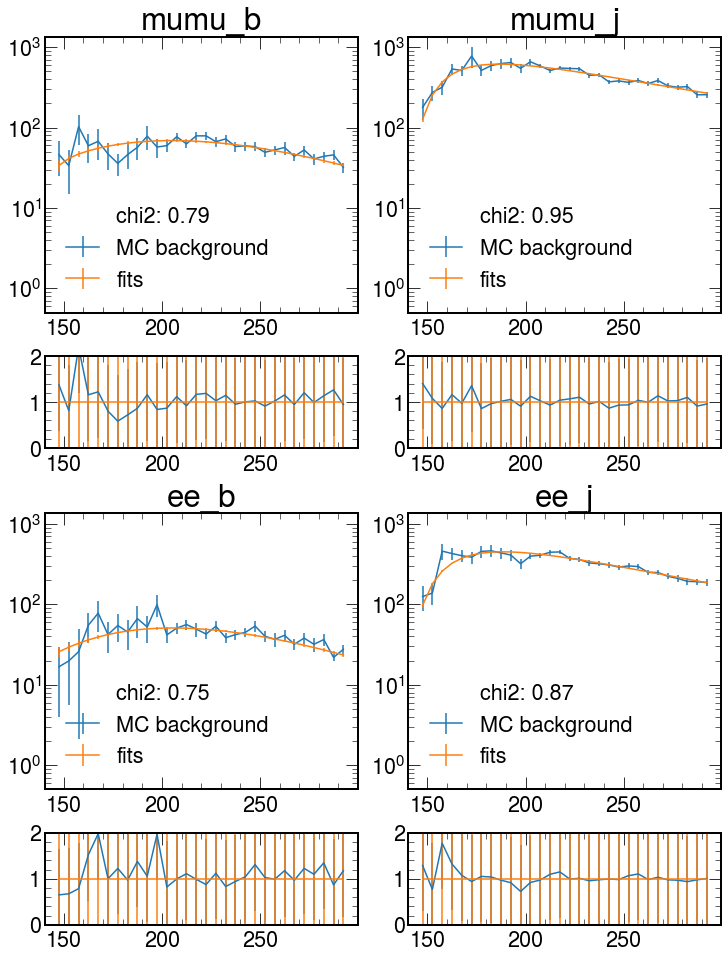

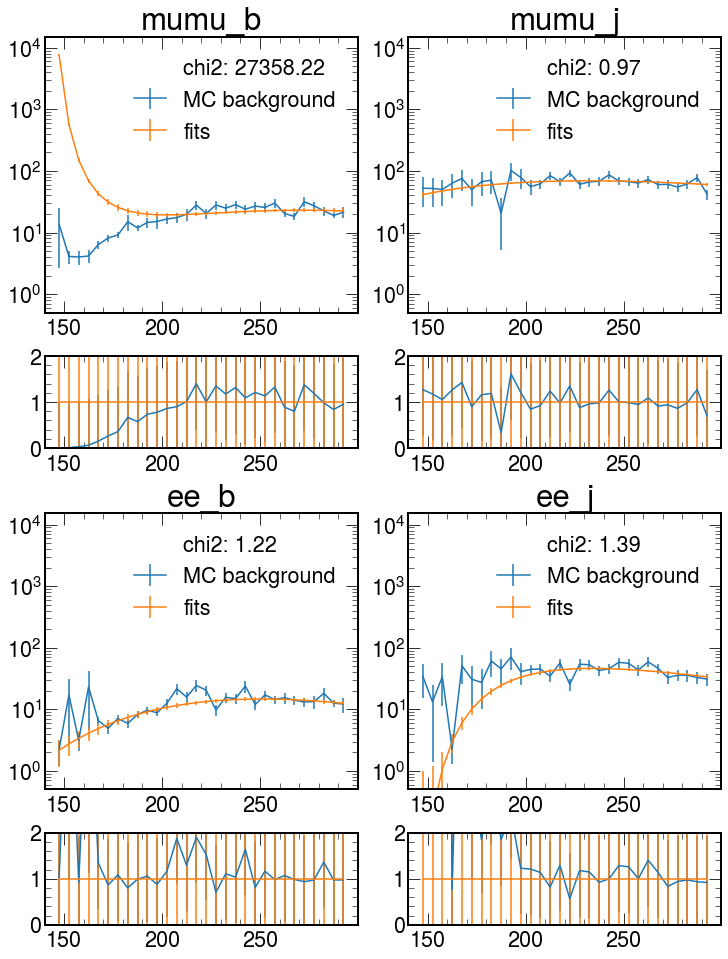

In [197]:
make_abcd_subplots(1,bckground,fit)
make_abcd_subplots(2,bckground,fit)

In [198]:
abcd_fits_1,popt_data_1 = abcd_fiter(data,1)
abcd_fits_2,popt_data_2 = abcd_fiter(data,2)

regions = {"SR1":abcd_fits_1[0],"CR10":abcd_fits_1[1],"CR13":abcd_fits_1[2],"CR14":abcd_fits_1[3]
 ,"SR2":abcd_fits_2[0],"CR20":abcd_fits_2[1],"CR23":abcd_fits_2[2],"CR24":abcd_fits_2[3]}


fit_data = Sample.from_regions("fits",regions)

Name: 0 Sum:0.00 Var:0.00 Range:145.0-295.0 nBins: 30
norm_mumu_j: 1019.55
norm_ee_b: 102.50
norm_ee_j: 693.61
sigma_mumu_j: 0.86
sigma_ee_b: 0.69
sigma_ee_j: 0.79
theta_mumu_j: 137.95
theta_ee_b: 124.00
theta_ee_j: 136.53
mean_mumu_j: 83.79
mean_ee_b: 94.30
mean_ee_j: 84.63
slope_mumu_j: 1.00
slope_ee_b: 0.88
slope_ee_j: 0.95
Name: 0 Sum:0.00 Var:0.00 Range:145.0-295.0 nBins: 30
norm_mumu_j: 908.60
norm_ee_b: 80.38
norm_ee_j: 417.02
sigma_mumu_j: 1.15
sigma_ee_b: 0.33
sigma_ee_j: 0.30
theta_mumu_j: 139.00
theta_ee_b: 0.00
theta_ee_j: 0.00
mean_mumu_j: 138.43
mean_ee_b: 238.47
mean_ee_j: 212.47
slope_mumu_j: 0.26
slope_ee_b: 0.40
slope_ee_j: 0.25


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


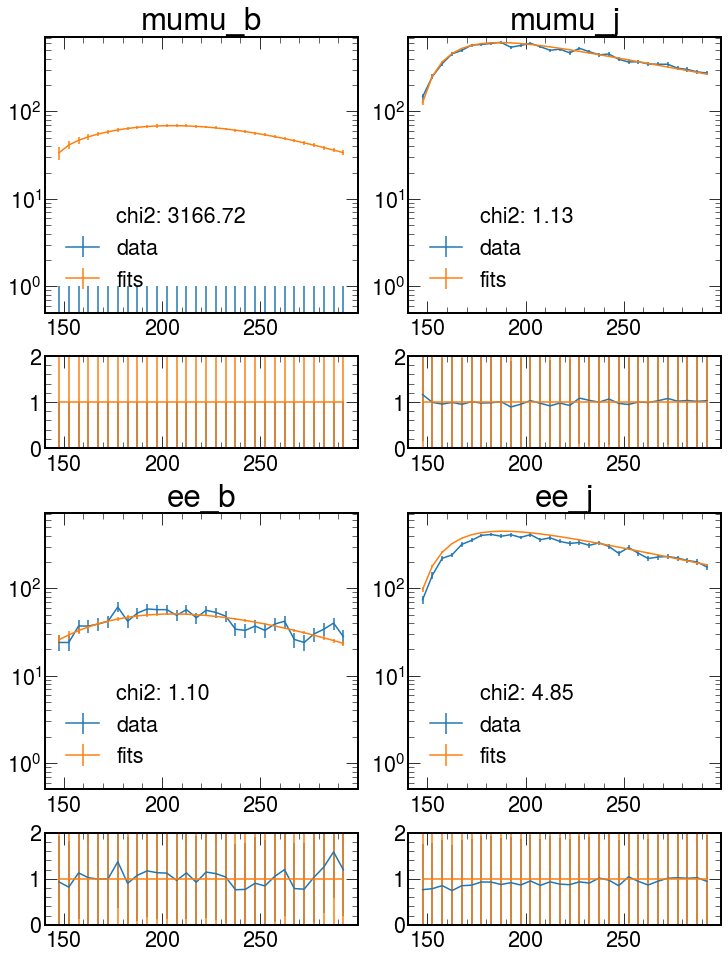

In [ ]:
make_abcd_subplots(1,data,fit)
make_abcd_subplots(2,data,fit)

In [ ]:
bin_center, _, CR = fit.abcd_assets(2)
bin_center, _, CR_data = data.abcd_assets(2)


y_fit = abcd_fit(x,*popt_data_2)
plt.plot(CR[1])
#plt.plot(CR_data[1])
plt.plot(CR[0])
plt.plot(CR_data[0])
plt.yscale('log')

In [ ]:
y = data.regions_range['CR24'].val
x = data.regions_range['CR24'].bin_center()

popt, pcov =curve_fit(log_norm,x,y)
fit = log_norm(x,*popt)
plt.plot(x,y)
plt.plot(x,fit)
plt.yscale('log')
plt.ylim(bottom=1)

In [117]:
import scipy.stats as sts
h = data.regions['CR13'].var
e = data.regions['CR13'].bin_edges
x = data.regions['CR13'].bin_center()
bin_width = (-e[:-1] + e[1:])
n=1000
resamples = np.random.choice((e[:-1] + e[1:])/2, size=n*5, p=h/h.sum())
rkde = sts.gaussian_kde(resamples)


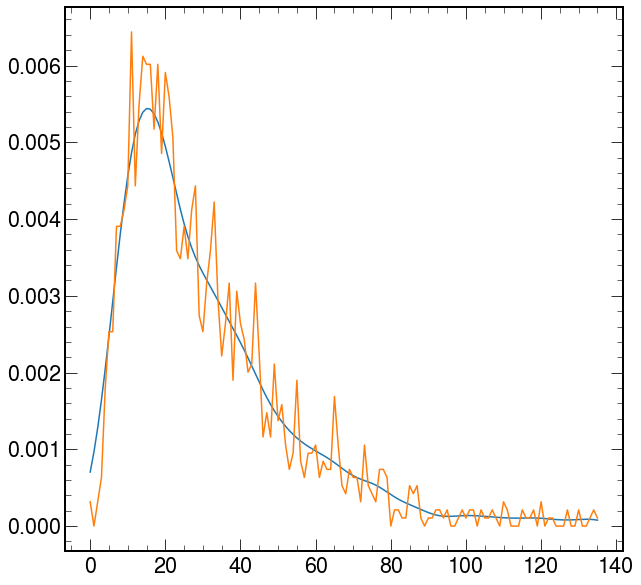

In [118]:
plt.plot(rkde.pdf(x))
plt.plot(h/(h.sum()*bin_width))

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


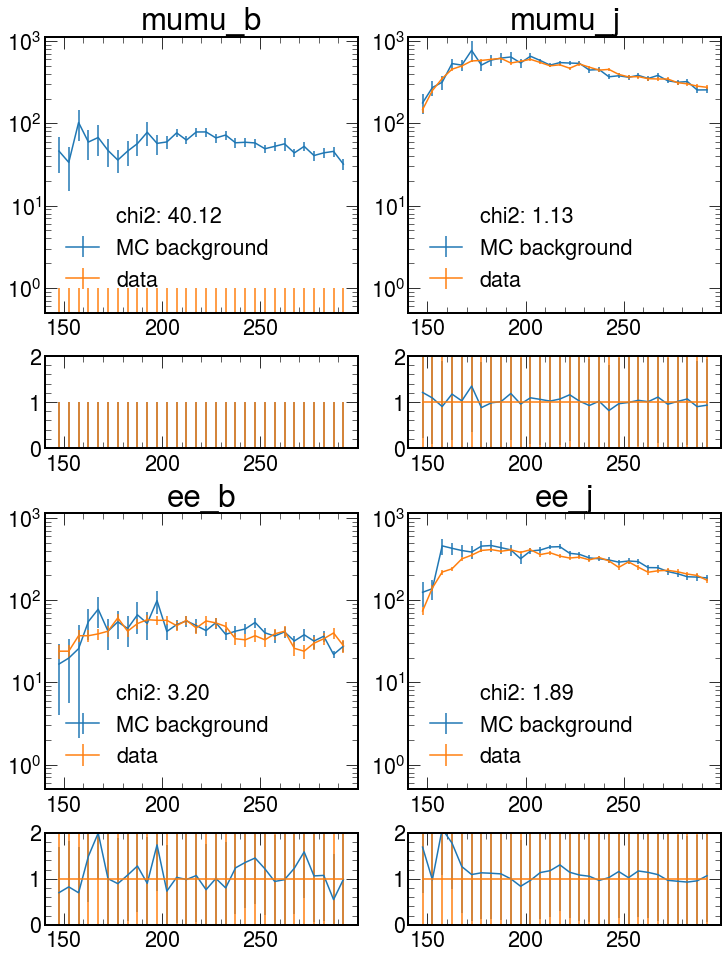

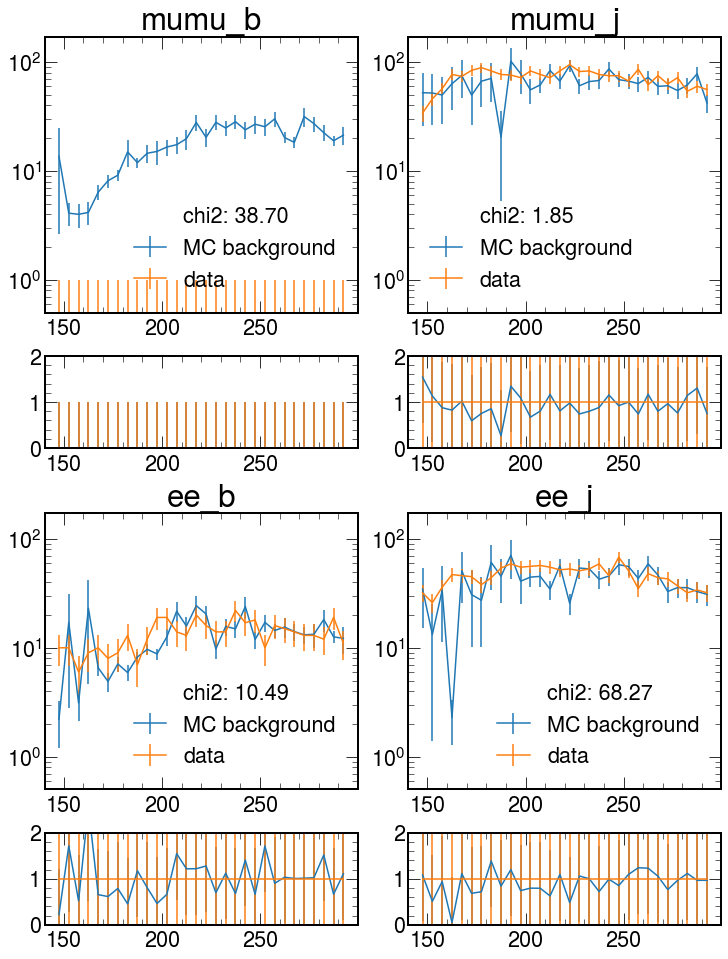

In [119]:
make_abcd_subplots(1,bckground,data)
make_abcd_subplots(2,bckground,data)

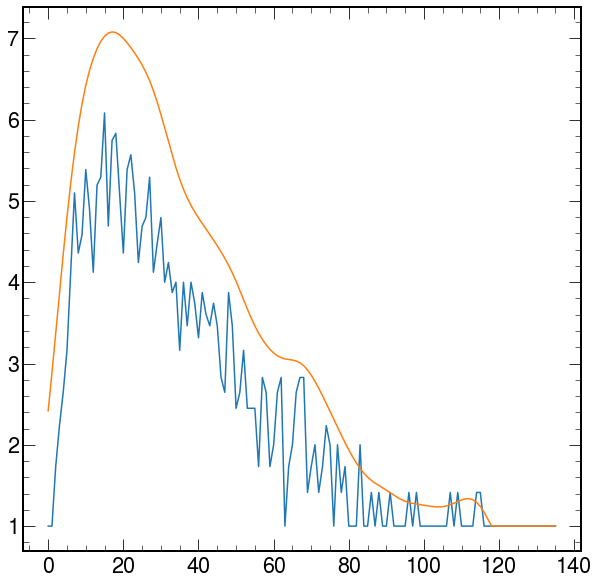

In [46]:
plt.plot(data.regions['CR13'].stdev())
plt.plot(data.regions['CR13'].stdev(kde=1))

In [148]:
def log_norm(x, norm, sigma, theta, mean,slope,numpy_like=np):
    theta  = min(theta,140)
    return norm/((x-theta)*sigma*2*3.14159)*np.exp(-(np.log((x-theta)/mean))**2/(2*sigma**2))*(slope*x)


In [ ]:
 ee_j = log_norm(bins, norm_ee_j, sigma_ee_j, theta_ee_j, mean_ee_j, slope_ee_j,numpy_like=numpy_like)
    
curve_fit(abcd_fit,bin_center,CR[0],
                    p0=np.asarray([
1000.21,98.72,723.70,
0.72, 0.62, 0.72,
127.62, 106.32, 127.34,
88.79,114.07,90.59,
0.99,0.96,1.00,]),
                    bounds=(0, [
                            np.inf, np.inf, np.inf,
                            np.inf, np.inf, np.inf,
                            xmin-1, xmin-1, xmin-1,
                            np.inf, np.inf, np.inf,
                            np.inf, np.inf, np.inf,
                    ]),
                    sigma = (CR[1]),
                    absolute_sigma=True)